In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA

plt.style.use("default_light")

FOLDER = "../../results/20220304_random_data_stuff_200subjects_20channels_4states/"

In [2]:
data = pd.read_csv(os.path.join(FOLDER, "data_and_segmentation.csv"), index_col=[0, 1])
stats = pd.read_csv(os.path.join(FOLDER, "basic_stats.csv"), index_col=0)
dynstats = pd.read_csv(os.path.join(FOLDER, "dyn_stats.csv"), index_col=0)
maps = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))

<AxesSubplot:xlabel='algorithm', ylabel='value'>

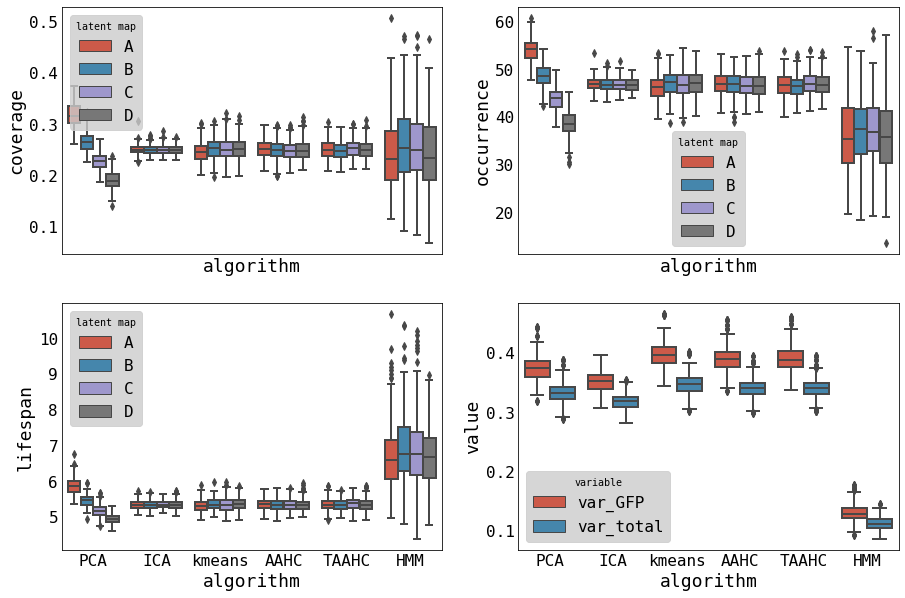

In [3]:
_, axs = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(15, 10))
sns.boxplot(data=stats, x="algorithm", y="coverage", hue="latent map", ax=axs[0, 0])
sns.boxplot(data=stats, x="algorithm", y="occurrence", hue="latent map", ax=axs[0, 1])
sns.boxplot(data=stats, x="algorithm", y="lifespan", hue="latent map", ax=axs[1, 0])
sns.boxplot(
    data=stats.melt(id_vars=["algorithm"], value_vars=["var_GFP", "var_total"]),
    x="algorithm",
    y="value",
    hue="variable",
    ax=axs[1, 1],
)

<AxesSubplot:xlabel='algorithm', ylabel='value'>

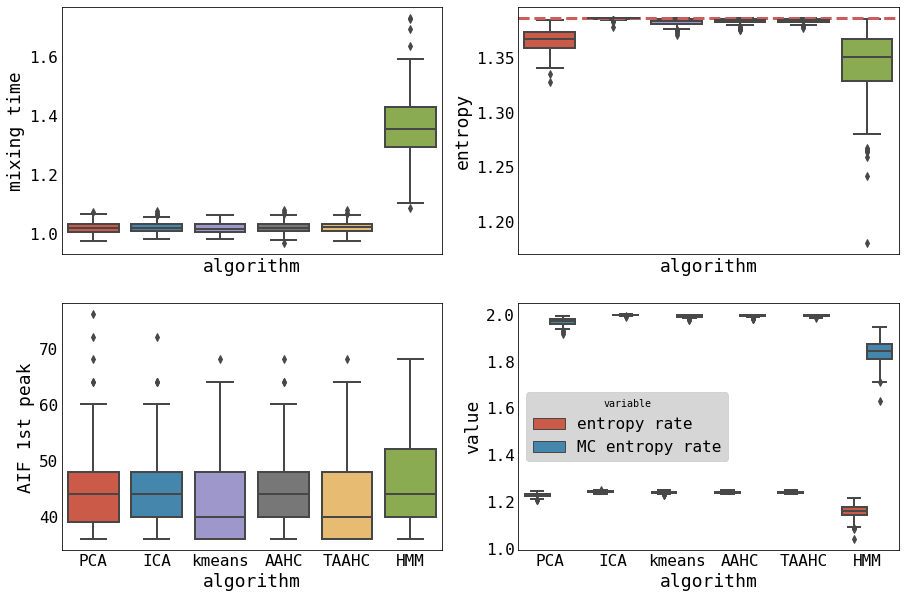

In [4]:
_, axs = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(15, 10))
sns.boxplot(data=dynstats, x="algorithm", y="mixing time", ax=axs[0, 0])
sns.boxplot(data=dynstats, x="algorithm", y="entropy", ax=axs[0, 1])
axs[0, 1].axhline(
    dynstats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
sns.boxplot(data=dynstats, x="algorithm", y="AIF 1st peak", ax=axs[1, 0])
sns.boxplot(
    data=dynstats.melt(
        id_vars=["algorithm"], value_vars=["entropy rate", "MC entropy rate"]
    ),
    x="algorithm",
    y="value",
    hue="variable",
    ax=axs[1, 1],
)

In [6]:
prep = (
    data.sort_index()
    .reset_index()
    .drop(["time"] + list(data.filter(like="chan").columns), axis=1)
    .groupby("subject")
    .corr("spearman")
    .abs()
    .unstack()
)

mean = prep.mean().reset_index().pivot(index="level_0", columns="level_1")
std = prep.std(ddof=1).reset_index().pivot(index="level_0", columns="level_1")
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

0                                        \
level_1               AAHC                HMM                ICA   
level_0                                                            
AAHC         1.0 $\pm$ 0.0   0.06 $\pm$ 0.046  0.161 $\pm$ 0.114   
HMM       0.06 $\pm$ 0.046      1.0 $\pm$ 0.0   0.056 $\pm$ 0.04   
ICA      0.161 $\pm$ 0.114   0.056 $\pm$ 0.04      1.0 $\pm$ 0.0   
PCA      0.129 $\pm$ 0.106  0.062 $\pm$ 0.045  0.175 $\pm$ 0.135   
TAAHC    0.255 $\pm$ 0.166   0.06 $\pm$ 0.044  0.163 $\pm$ 0.128   
kmeans   0.244 $\pm$ 0.157  0.061 $\pm$ 0.046  0.198 $\pm$ 0.146   

                                                                  
level_1                PCA              TAAHC             kmeans  
level_0                                                           
AAHC     0.129 $\pm$ 0.106  0.255 $\pm$ 0.166  0.244 $\pm$ 0.157  
HMM      0.062 $\pm$ 0.045   0.06 $\pm$ 0.044  0.061 $\pm$ 0.046  
ICA      0.175 $\pm$ 0.135  0.163 $\pm$ 0.128  0.198 $\pm$ 0.146  
PCA          1.0 $\pm$ 0.0  0.149 $\pm$ 0.108  0.176 $\pm$ 0.116  
TAAHC    0.149 $\pm$ 0.108      1.0 $\pm$ 0.0  0.272 $\pm$ 0.163  
kmeans   0.176 $\pm$ 0.116  0.272 $\pm$ 0.163      1.0 $\pm$ 0.0

In [7]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

In [8]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

0                                        \
alg2                 AAHC                HMM                ICA   
alg1                                                              
AAHC        1.0 $\pm$ 0.0  0.504 $\pm$ 0.108  0.863 $\pm$ 0.069   
HMM     0.504 $\pm$ 0.108      1.0 $\pm$ 0.0  0.499 $\pm$ 0.098   
ICA     0.863 $\pm$ 0.069  0.499 $\pm$ 0.098      1.0 $\pm$ 0.0   
PCA     0.884 $\pm$ 0.062  0.498 $\pm$ 0.093  0.877 $\pm$ 0.072   
TAAHC   0.952 $\pm$ 0.036  0.504 $\pm$ 0.102  0.853 $\pm$ 0.075   
kmeans   0.94 $\pm$ 0.045  0.511 $\pm$ 0.098  0.866 $\pm$ 0.076   

                                                                 
alg2                  PCA              TAAHC             kmeans  
alg1                                                             
AAHC    0.884 $\pm$ 0.062  0.952 $\pm$ 0.036   0.94 $\pm$ 0.045  
HMM     0.498 $\pm$ 0.093  0.504 $\pm$ 0.102  0.511 $\pm$ 0.098  
ICA     0.877 $\pm$ 0.072  0.853 $\pm$ 0.075  0.866 $\pm$ 0.076  
PCA         1.0 $\pm$ 0.0  0.891 $\pm$ 0.059  0.892 $\pm$ 0.053  
TAAHC   0.891 $\pm$ 0.059      1.0 $\pm$ 0.0  0.949 $\pm$ 0.039  
kmeans  0.892 $\pm$ 0.053  0.949 $\pm$ 0.039      1.0 $\pm$ 0.0

In [9]:
mean = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .mean("subject")
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
std = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .std("subject", ddof=1)
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,rho
algorithm,
AAHC,0.504 $\pm$ 0.099
HMM,0.559 $\pm$ 0.081
ICA,0.185 $\pm$ 0.066
PCA,0.059 $\pm$ 0.041
TAAHC,0.496 $\pm$ 0.1
kmeans,0.419 $\pm$ 0.102


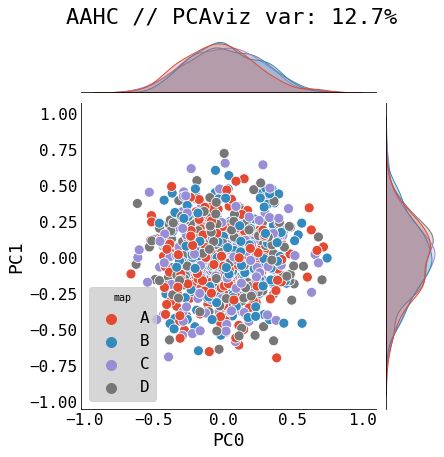

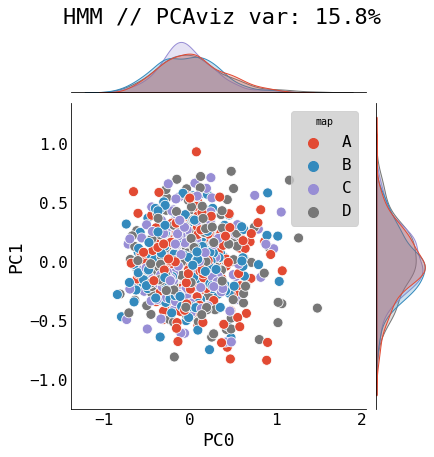

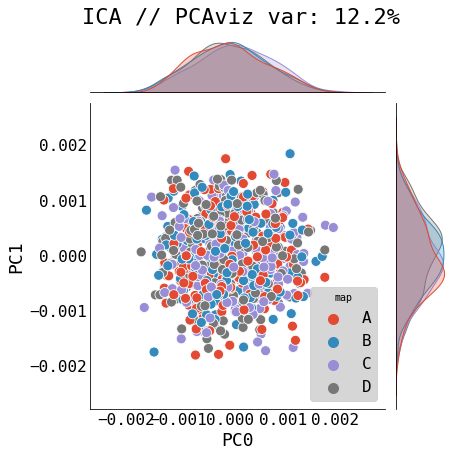

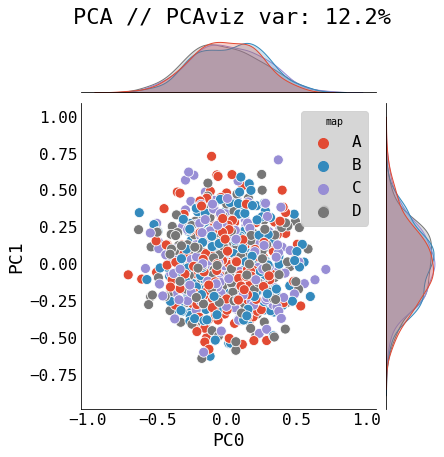

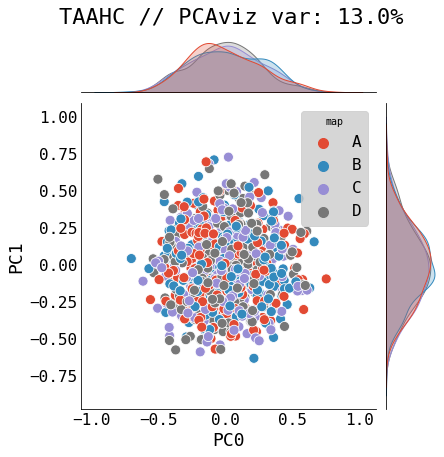

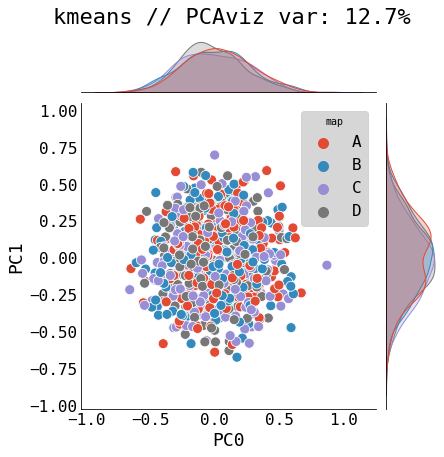

In [10]:
for decomp in maps["algorithm"]:
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["PC0", "PC1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="PC0", y="PC1", hue="map")
    g.fig.suptitle(
        f"{decomp.values} // PCAviz var: {pca.explained_variance_ratio_.sum():.1%}",
        y=1.05,
    )
    plt.show()